# Assignment 1: Time Series Forecast With Python (Seasonal ARIMA)

**Lecturer**: Vincent Claes<br>
**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

**Description:** In this notebook we take a close look at the data

## Table of contents

1. [Import libraries](#Import-Libraries)
2. [Load in the data](#load-data)
3. [Wrange the data](#)
4. [A bit of Exploratory Data Analysis (EDA)](#EDA) 

## 1. Import Libraries <a name="Import-Libraries"></a>

In [1]:
import warnings

import pandas            as pd
import seaborn           as sns
import itertools         as it
import statsmodels.api   as sm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## 2. Load in the data <a name="load-data"></a>

In [2]:
data_csv = pd.read_csv('./data/data.csv')

In [3]:
data_csv.tail(5)

,dateTime,temperature
837,2018-11-19 16:45:00,17.22
838,2018-11-19 17:00:00,17.47
839,2018-11-19 17:15:00,16.02
840,2018-11-19 17:30:00,16.30
841,2018-11-19 17:45:00,15.16


In [4]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 2 columns):
dateTime       842 non-null object
temperature    842 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.2+ KB


## 3. Wrangle the Data <a name="Wrangle-the-Data"></a>

Since we want our dataframe to be a time series we will have to convert our index because, at this moment it is not a ```datetimeIndex```.<br>
We can do this with the help of the ```pandas``` methods ```to_datetime()``` and ```set_index```.

In [5]:
data = pd.DataFrame()

# Convert the creation_date column to datetime64
data['dateTime'] = pd.to_datetime(data_csv['dateTime'])
# Convert the value column to float
data['temperature'] = pd.to_numeric(data_csv['temperature'])

# Set the dateTime column as index
data = data.set_index(['dateTime'])

# Sort the dataFrame just to be sure...
data = data.sort_index()

# Double check the results
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 842 entries, 2018-11-10 23:30:00 to 2018-11-19 17:45:00
Data columns (total 1 columns):
temperature    842 non-null float64
dtypes: float64(1)
memory usage: 13.2 KB


As we can see we successfully convert our index to a ```datetimeIndex``` thus making it a time series dataframe.

## 4. A bit of Exploratory Data Analysis (EDA) <a name="EDA"></a>

### Initial Inspections

We can have a look at how frequent some temperatures are. I rounded the values in the dataFrame since this resulted in a much nicer plot.

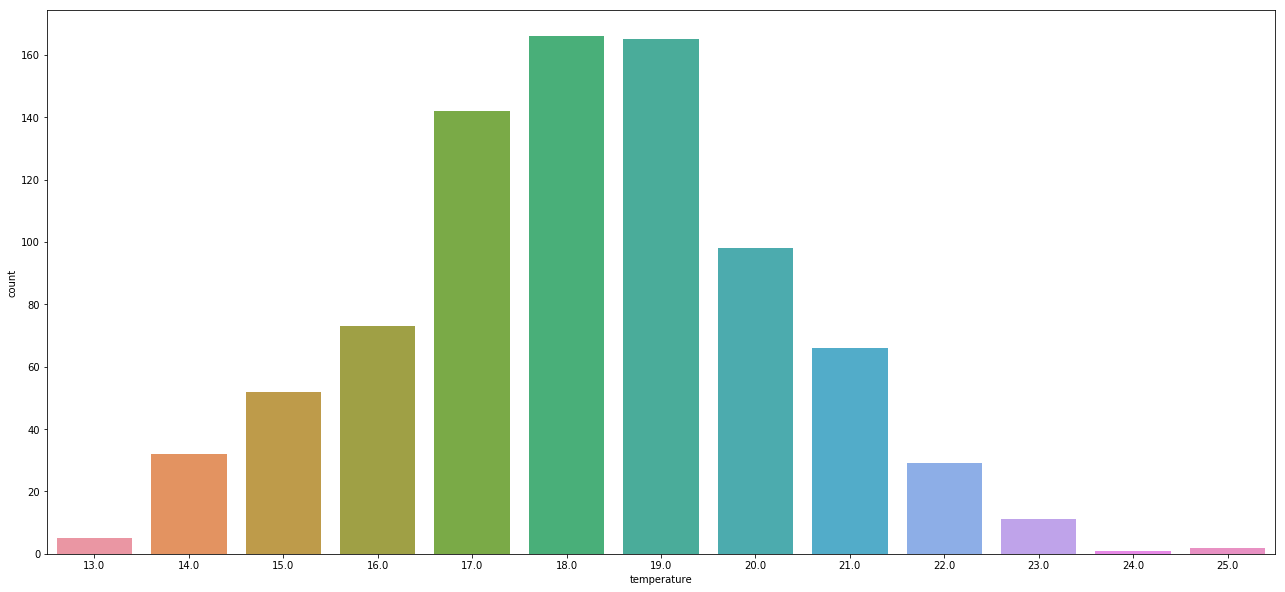

In [6]:
plt.figure(figsize=(22,10))
sns.countplot(data['temperature'].round())
plt.show()

In [7]:
print(data.describe())
print("======================")
print(data.dtypes)

       temperature
count   842.000000
mean     18.202672
std       2.033343
min      12.910000
25%      16.990000
50%      18.280000
75%      19.477500
max      25.260000
temperature    float64
dtype: object


In [8]:
data.head(5)

,temperature
dateTime,
2018-11-10 23:30:00,21.48
2018-11-10 23:45:00,20.32
2018-11-11 00:00:00,20.91
2018-11-11 00:15:00,21.33
2018-11-11 00:30:00,22.18


In [9]:
data.tail(5)

,temperature
dateTime,
2018-11-19 16:45:00,17.22
2018-11-19 17:00:00,17.47
2018-11-19 17:15:00,16.02
2018-11-19 17:30:00,16.30
2018-11-19 17:45:00,15.16


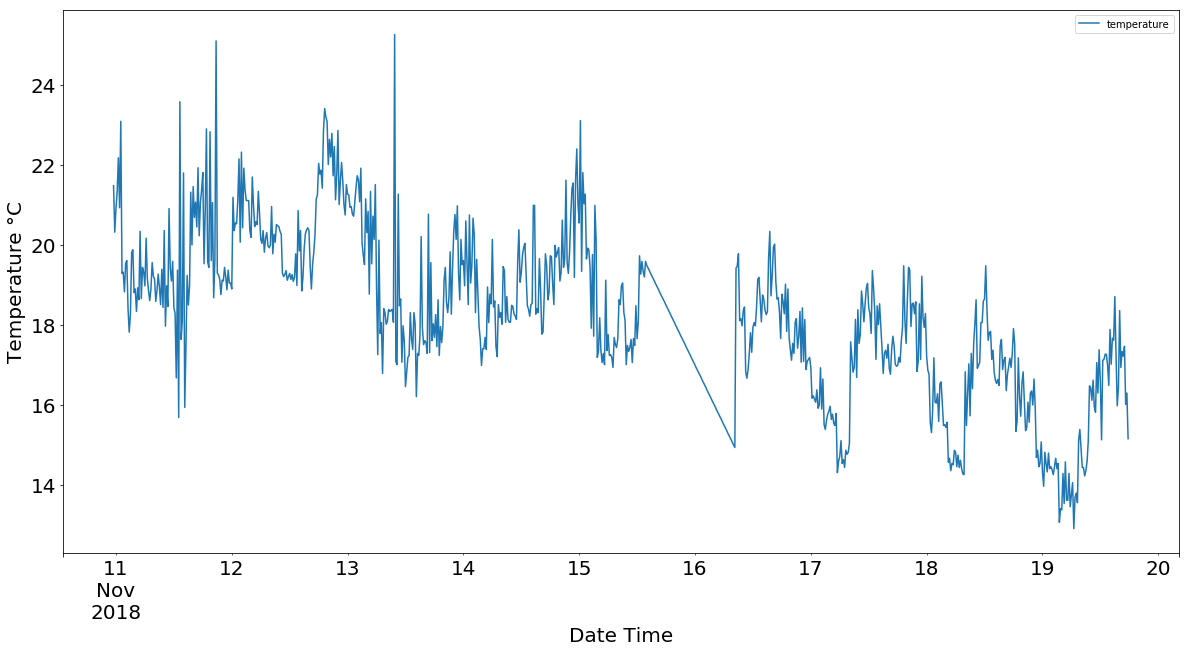

In [10]:
data.plot(figsize=(20, 10), fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

In [11]:
# Dickey Fuller Test Function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================================")
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

In [12]:
# Stationarity Check - Lets do a quick check on Stationarity with Dickey Fuller Test 
# Convert the DF to series first
ts = data['temperature']
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.788636
p-value                          0.059915
#lags Used                       9.000000
Number of Observations Used    832.000000
Critical Value (1%)             -3.438234
Critical Value (5%)             -2.865020
Critical Value (10%)            -2.568623
dtype: float64


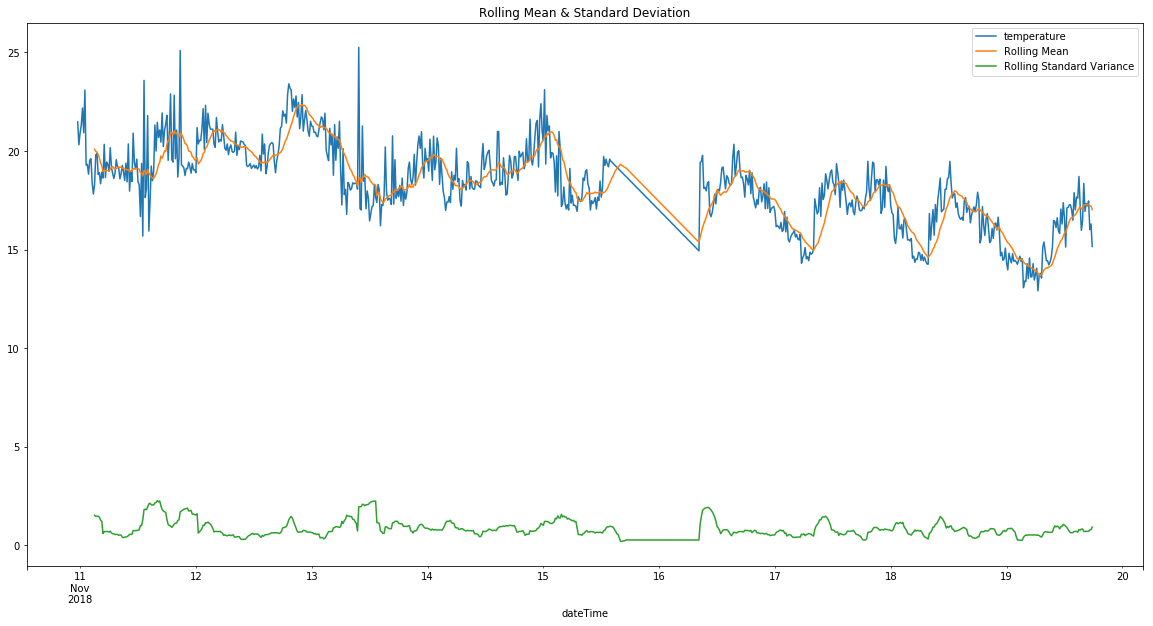

In [13]:
# Let's plot the 12-Month Moving Rolling Mean & Variance and find Insights
# Rolling Statistics
rolmean = ts.rolling(window=15).mean()
rolvar = ts.rolling(window=15).std()

data.plot(label='Original', figsize=(20, 10))
rolmean.plot(label='Rolling Mean')
rolvar.plot(label='Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

The ```Rolling Mean``` data looks perfect to train our model on so we will save it to a ```.csv```.

In [14]:
# Since you can see some of the data in the beginning is missing we will just drop all the NaN values
rolmean = rolmean.dropna()

rolmean.round(2).to_csv('./data/rolmean_data.csv',
                       header=['temperature'])

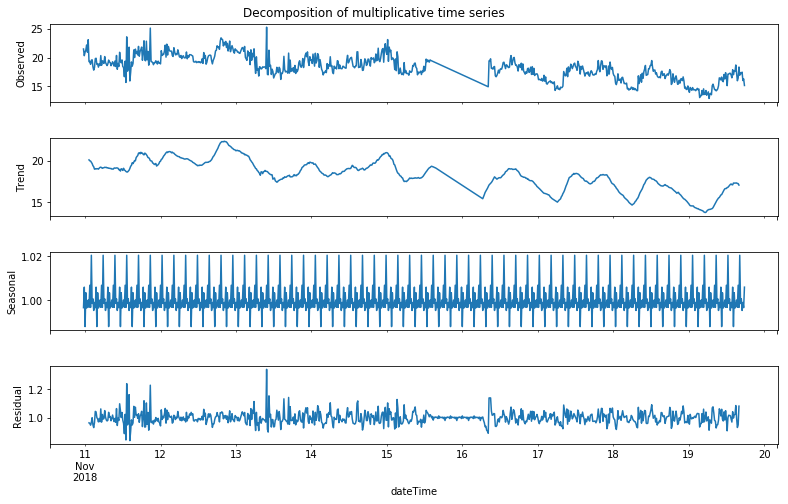

In [15]:
# Lets do a quick vanila decomposition to see any trend seasonality etc in the ts
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative', freq=15)

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()